In [1]:
import torch
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import tqdm
from functorch import vmap
torch.set_default_dtype(torch.float64)

import matplotlib.pyplot as plt

/home/peiyi/mambaforge3/envs/rom/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
a = torch.rand(1, 1, 20, 10, 100)
b = torch.rand(1, 1, 20, 10, 30)
torch.nn.functional.conv3d(a, b, padding='same').shape


/tmp/ipykernel_31347/920094141.py:3: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541990/work/aten/src/ATen/native/Convolution.cpp:895.)
  torch.nn.functional.conv3d(a, b, padding='same').shape


torch.Size([1, 1, 20, 10, 100])

In [3]:
device = torch.device("cuda")

In [4]:
data1 = torch.tensor(np.load("mu_0.9.npy"))
data2 = torch.tensor(np.load("mu_0.95.npy"))
data3 = torch.tensor(np.load("mu_1.05.npy"))
data4 = torch.tensor(np.load("mu_1.1.npy"))
X = torch.cat([data1, data2, data3, data4], axis=0)
(S, N) = X.shape

X_test = torch.tensor(np.load("mu_1.0.npy"))

In [5]:
x_ref = torch.mean(X, dim=0).to(device)

In [6]:
class NRBS(torch.nn.Module):
    def __init__(self, N, n, M1, mu):
        super(NRBS, self).__init__()

        self.mu = mu

        window_size = torch.arange(2 * mu)
        self.register_buffer('window_size', window_size)

        self.encoder1 = torch.nn.Linear(N, M1)
        self.encoder2 = torch.nn.Linear(M1, n)

        self.decoder = torch.nn.Linear(n, N)

        self.bs1 = torch.nn.Linear(n, N)
        self.bs2 = torch.nn.Linear(N, n)
        

        torch.nn.init.kaiming_normal_(self.encoder1.weight)
        torch.nn.init.kaiming_normal_(self.encoder2.weight)
        torch.nn.init.kaiming_normal_(self.decoder.weight)

    def bubble(self, w):
        x = self.get_buffer('window_size')
        window = torch.relu(- (x - self.mu)**2 / (w * self.mu)**2 + 1)
        window = window / torch.sum(window)
        return window

    def bs(self, x):
        x = self.bs1(x)
        x = torch.sigmoid(x)
        x = self.bs2(x)
        x = torch.sigmoid(x)
        return x

    def encode(self, x):
        x = self.encoder1(x)
        x = x * torch.sigmoid(x)
        x = self.encoder2(x)
        return x

    def decode(self, x):
        b = x.shape[0]
        bs = self.bs(x)

        vmap_bubble = vmap(self.bubble, in_dims=0)
        vmap_vmap_bubble = vmap(vmap_bubble, in_dims=0)
        # batch size x n x mu
        bubbles = vmap_vmap_bubble(bs)

        # print(bubbles.shape)

        basis = torch.nn.functional.conv3d(self.decoder.weight.T.unsqueeze(0).unsqueeze(0).unsqueeze(0).expand(-1, -1, b, -1, -1), bubbles.unsqueeze(0).unsqueeze(0), padding='same')
        basis = basis.squeeze(0).squeeze(0)

        # print(basis.shape)

        return torch.bmm(x.unsqueeze(1), basis).squeeze(
            1
        ) + self.decoder.bias.unsqueeze(0)

    def forward(self, x):
        return self.decode(self.encode(x))


In [7]:
n = 20
lr = 1e-3
epochs = 10000
B = 20
lr_red_factor = 0.1
patience = 10
l1_reg = 0

nrbs = NRBS(N, n, 100, 5).to(device)

In [8]:
# mask = nrbs.get_buffer('mask').cpu().detach().numpy()
# fig, ax = plt.subplots(figsize=(10, 10))
# ax.spy(mask, markersize=5, aspect='auto')

In [9]:
X = X.to(device)
X_test = X_test.to(device)
dataloader = torch.utils.data.DataLoader(X, batch_size=B, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(X_test, batch_size=B, shuffle=True)
optimizer = torch.optim.Adam(nrbs.parameters(), lr=lr, weight_decay=l1_reg)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", factor=lr_red_factor, patience=patience
)

loss_func = torch.nn.MSELoss()

best_loss = 1000
writer = SummaryWriter()
for epoch in range(1):
    for x in tqdm.tqdm(dataloader):
        optimizer.zero_grad()
        x_tilde = nrbs(x - x_ref) + x_ref
        
        l = torch.sum((x_tilde - x) ** 2)
        l.backward()
        optimizer.step()

    l_train = 0
    l_test = 0
    with torch.no_grad():
        for x in tqdm.tqdm(dataloader):
            X_tilde = nrbs(x - x_ref)
            l_train = l_train + torch.sum((x - X_tilde) ** 2)
        for x in tqdm.tqdm(test_dataloader):
            X_tilde = nrbs(x - x_ref)
            l_test = l_test + torch.sum((x - X_tilde) ** 2)

        l_test = torch.sqrt(l_test) / torch.sqrt(torch.sum(X_test**2))
        l_train = torch.sqrt(l_train) / torch.sqrt(torch.sum(X**2))
        l_train_mse = l_train / 3600 / len(dataloader.dataset)  

    if (l_test < best_loss):
        best_loss = l_test
        torch.save(nrbs, 'models/shallow_mask.pth')
        

    scheduler.step(l_train)

    writer.add_scalar("loss/train", l_train, epoch)
    writer.add_scalar("loss/test", l_test, epoch)
    writer.add_scalar("loss/mse_train", l_train_mse, epoch)
    
    writer.add_scalar("lr", optimizer.param_groups[0]["lr"], epoch)
    print("epoch: {:}".format(epoch))
    print("loss/test: {:}".format(l_test))
    print("loss/train: {:}".format(l_train))
    print("loss/mse_train: {:}".format(l_train_mse))
    print("lr: {:}".format(optimizer.param_groups[0]["lr"]))


  9%|▊         | 26/301 [01:36<16:58,  3.70s/it]


KeyboardInterrupt: 

In [ ]:
# torch.save(nrbs, 'models/shallow_mask.pth')

In [ ]:
# nrbs = torch.load('models/shallow_mask.pth')
input = X_test[-20:-1].to(device) - x_ref
encoded = nrbs.encode(input)
decoded = nrbs.decode(encoded)

In [ ]:
decoded.shape

torch.Size([19, 3600])

In [ ]:
basis = torch.zeros(n, N)
for i in range(N):
    test = torch.zeros_like(decoded)
    test[i] = 1
    basis[:, i] = torch.autograd.grad(decoded, encoded, test, retain_graph=True)[0]

RuntimeError: expand(torch.cuda.DoubleTensor{[19, 20]}, size=[20]): the number of sizes provided (1) must be greater or equal to the number of dimensions in the tensor (2)

In [ ]:
x = np.load('paper_x.npy')
y = np.load('paper_y.npy')

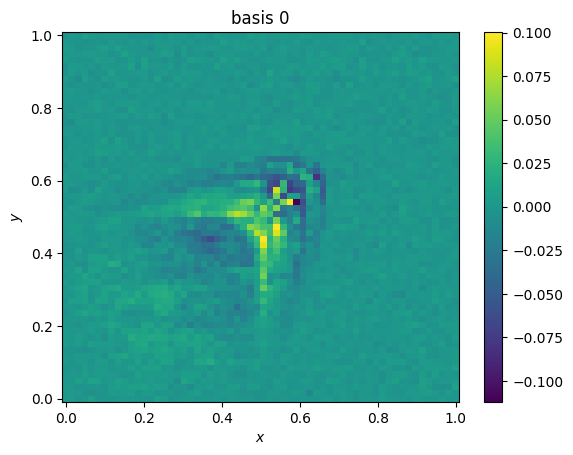

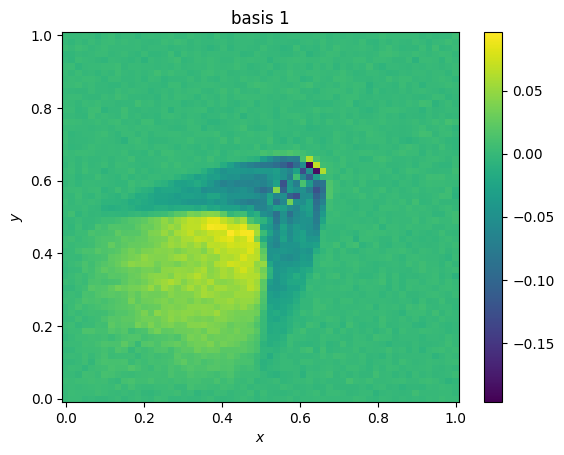

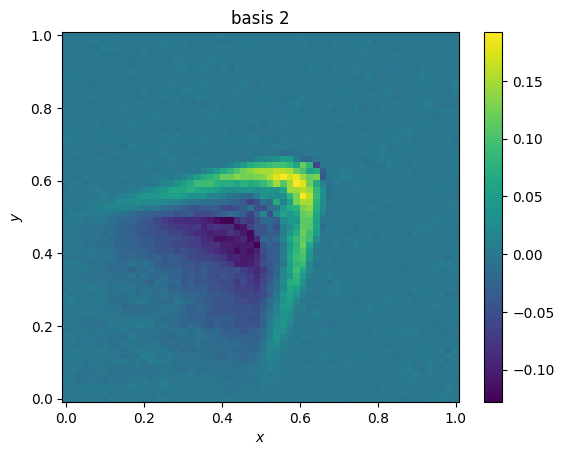

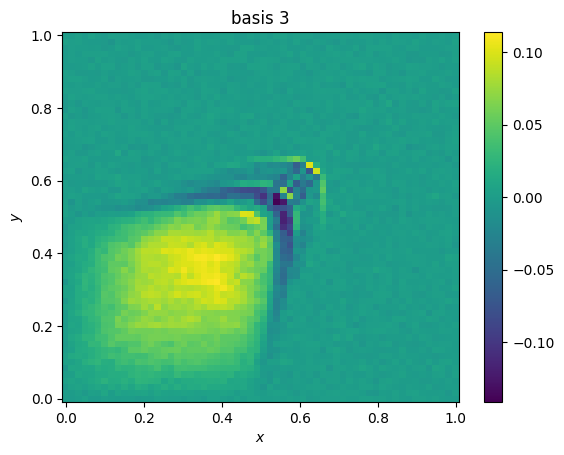

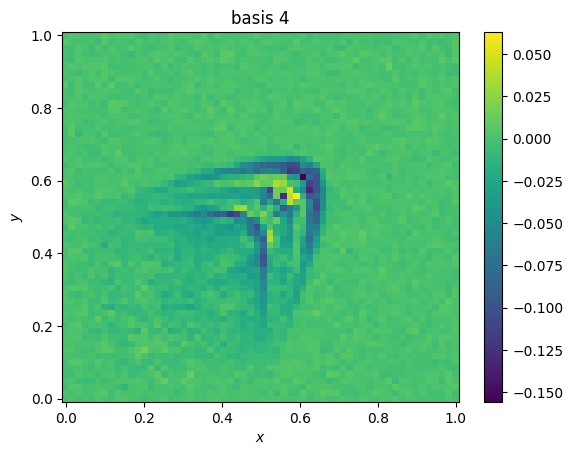

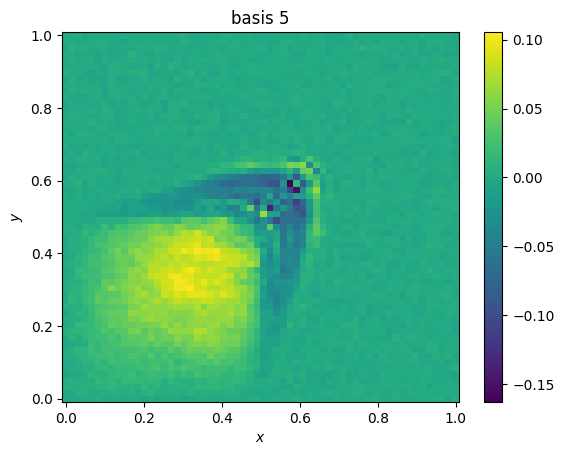

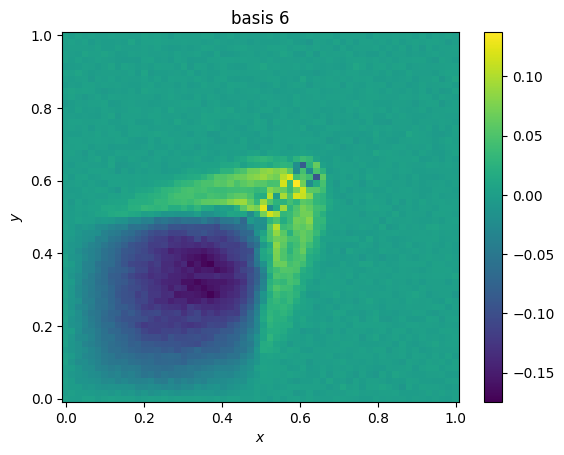

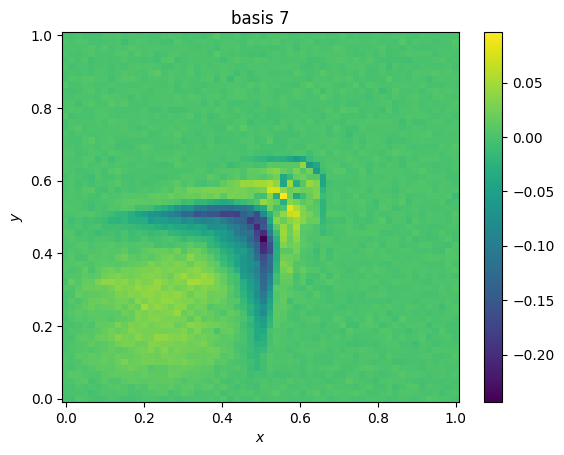

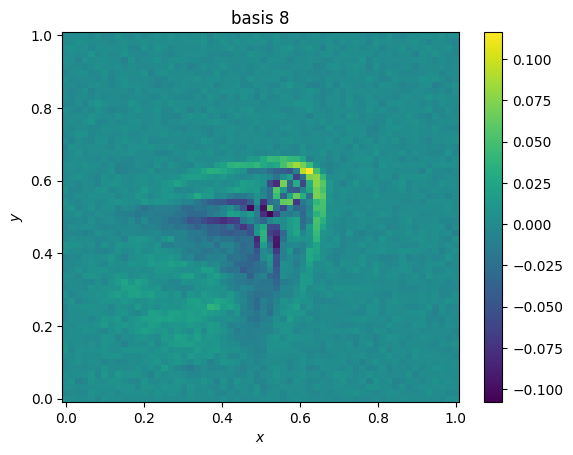

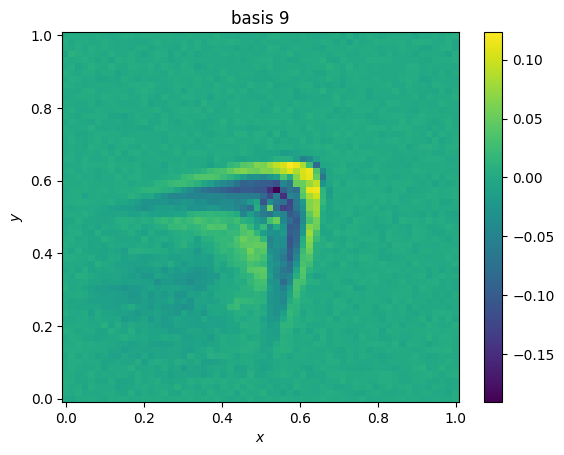

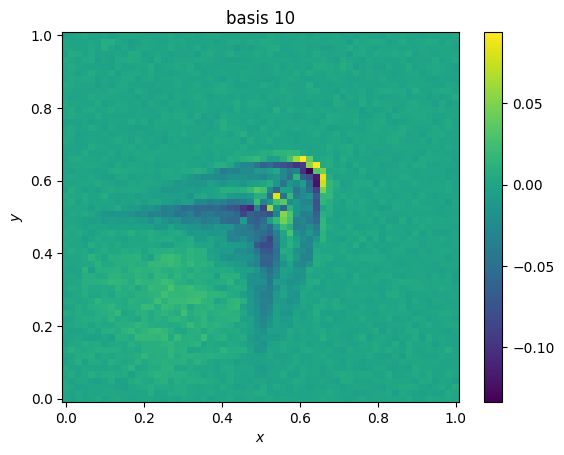

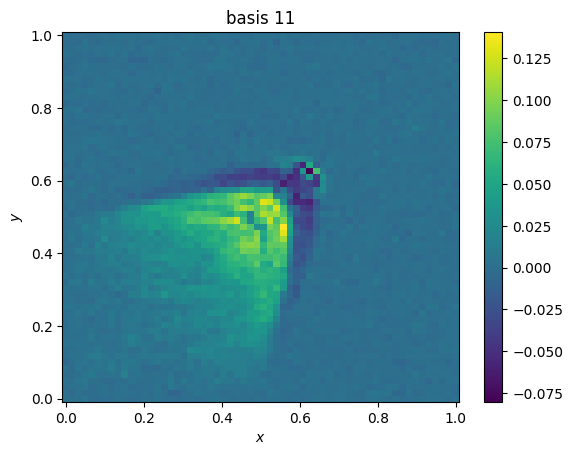

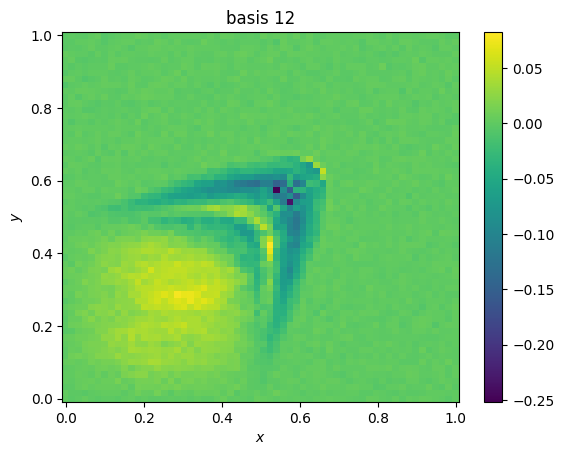

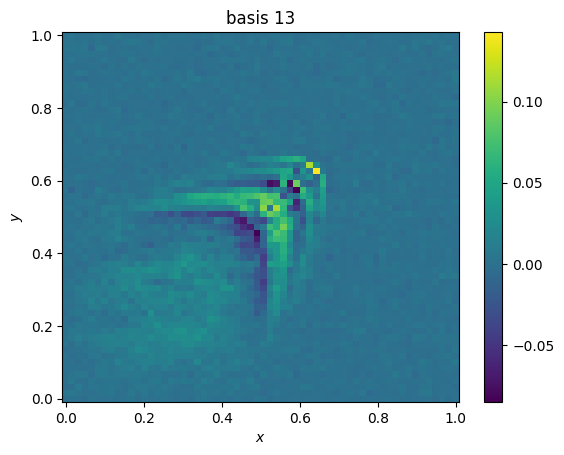

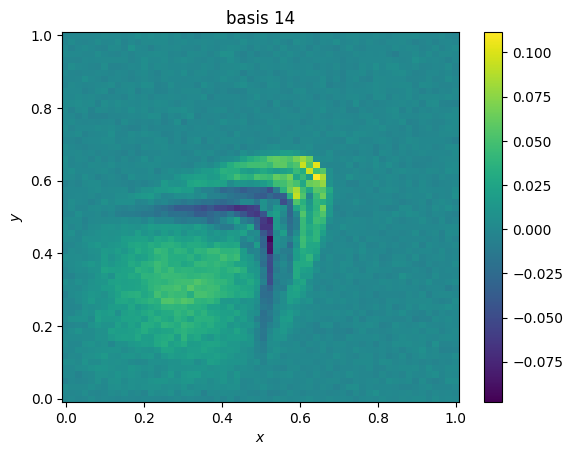

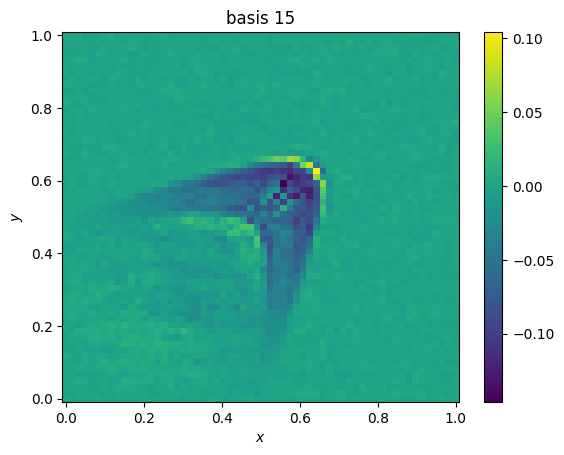

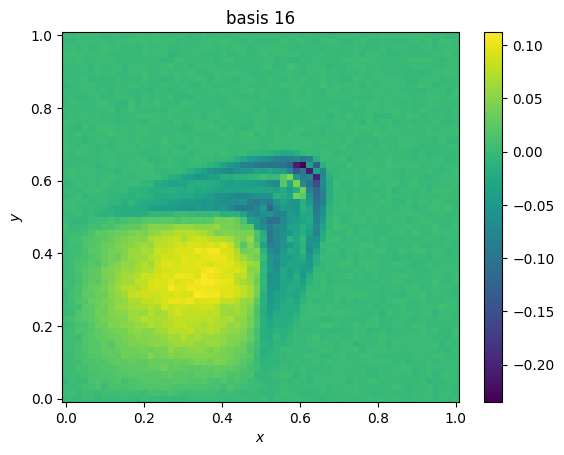

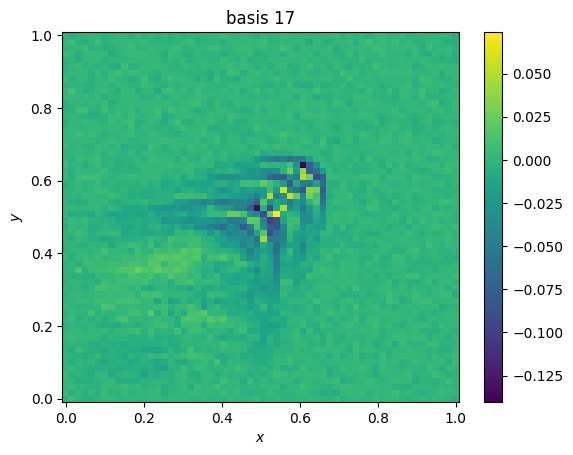

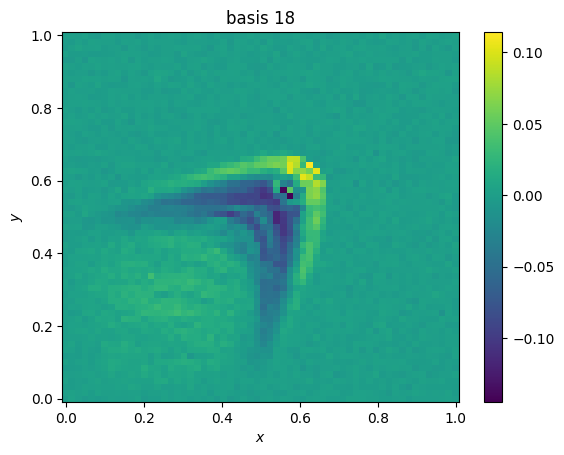

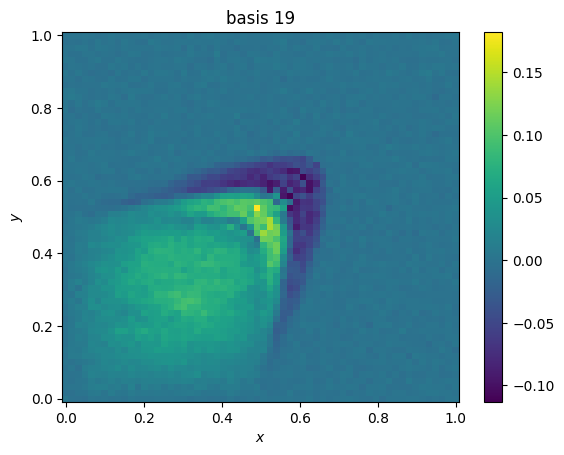

In [ ]:
ny = 60
nx = 60

for i in range(n):
    # plot
    fig_u = plt.figure()
    # ax_u = Axes3D(fig_u)
    # ax_u.plot_surface(x.reshape(ny,nx), y.reshape(ny,nx), u_full[-1].reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
    # ax_u.view_init(elev=30,azim=30)
    ax_u = fig_u.gca()
    p_u=ax_u.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), (basis[i]).reshape(ny,nx))
    cb_u=fig_u.colorbar(p_u,ax=ax_u)
    ax_u.set_xlabel('$x$')
    ax_u.set_ylabel('$y$')
    plt.title('basis ' + str(i))
    plt.show()